1. Підготовка середовища:
  * Встановіть необхідні бібліотеки: TensorFlow або PyTorch, numpy, matplotlib (для візуалізації).

In [1]:
# Встановіть необхідні бібліотеки: TensorFlow або PyTorch, numpy, matplotlib (для візуалізації).
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

2. Завантаження та попередня обробка даних:
  * Завантажте набір даних MNIST. Він містить 60,000 зображень для навчання та 10,000 зображень для тестування.
  * Нормалізуйте значення пікселів до діапазону [0, 1].
  * Розділіть дані на навчальну та тестову вибірки.

In [2]:
#Завантажте набір даних MNIST. Він містить 60,000 зображень для навчання та 10,000 зображень для тестування.
train_dataset = torchvision.datasets.MNIST(root='./data', download=True,train=True)
test_dataset = torchvision.datasets.MNIST(root='./data', download=True,train=False)

#Нормалізуйте значення пікселів до діапазону [0, 1]
train_images = train_dataset.data.float() / 255.0
train_labels = train_dataset.targets
train_dataset = TensorDataset(train_images, train_labels)

test_images = test_dataset.data.float() / 255.0
test_labels = test_dataset.targets
test_dataset = TensorDataset(test_images, test_labels)

3. Створення архітектури нейронної мережі:
  * Визначте базову нейронну мережу з використанням кількох шарів:
    * Вхідний шар: 28x28 (784) нейронів.
    * Один або два прихованих шари з активуючою функцією ReLU.
    * Вихідний шар з 10 нейронами (відповідають 10 цифрам), з функцією активації softmax.


In [3]:
class NNClassifier(nn.Module):
    def __init__(self):
        super(NNClassifier, self).__init__()
                
        self.flatten = nn.Flatten()
                
        self.layers = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.Softmax(dim=1) 
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x

4. Налаштування параметрів навчання:
  * Визначте функцію втрат, наприклад, cross-entropy loss.
  * Виберіть оптимізатор, наприклад, SGD або Adam.
  * Визначте кількість епох для навчання та розмір батчу.

In [4]:
model  = NNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs=5
batch_size = 64
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

print(f'Device: {device}')

Device: mps


5. Навчання моделі:
  * Запустіть процес навчання моделі на навчальній вибірці.
  * Періодично обчислюйте втрати та точність на тестовій вибірці для оцінки процесу навчання.

In [5]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=32, 
                         shuffle=False)
train_losses = []
test_losses = []
test_accuracies = []

model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss_train = 0
    total_loss_test = 0
    correct = 0
    total = 0
    
    for  images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward 
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss_train += loss.item()
    
    # Eval on test set
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)   
        outputs = model(images)
 
        preds = outputs.argmax(dim=1).to(device)
        correct += (preds == labels).sum().item()
        test_loss = criterion(outputs, labels)
        total_loss_test += test_loss.item()

    avg_loss_train = total_loss_train / len(train_loader)
    avg_loss_test = total_loss_test / len(test_loader)
    accuracy = 100 * correct / len(test_loader.dataset)

    train_losses.append(avg_loss_train)
    test_losses.append(avg_loss_test)
    test_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss_train:.4f}, Test Loss: {total_loss_test:.4f}, Test Accuracy: {accuracy:.4f}")


Epoch [1/5], Train Loss: 2920.9028, Test Loss: 473.2007, Test Accuracy: 95.0800
Epoch [2/5], Train Loss: 2830.5723, Test Loss: 471.1116, Test Accuracy: 95.6700
Epoch [3/5], Train Loss: 2814.6660, Test Loss: 468.8935, Test Accuracy: 96.3800
Epoch [4/5], Train Loss: 2805.3749, Test Loss: 468.4564, Test Accuracy: 96.4100
Epoch [5/5], Train Loss: 2802.3982, Test Loss: 468.5148, Test Accuracy: 96.4400


6. Оцінка моделі:
  * Після навчання моделі обчисліть її точність на тестовому наборі даних.
  * Побудуйте матрицю невідповідностей для детальнішого аналізу результатів.


Test set: Average loss: 1.4969, Accuracy: 9644/10000 (96.44%)



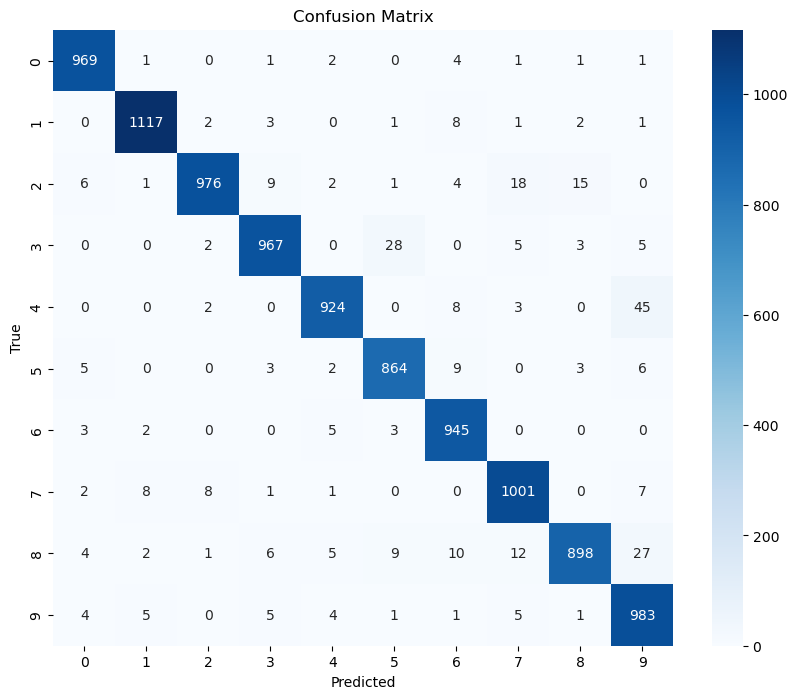

In [6]:
test_loss = 0
correct = 0
all_predictions = []
all_labels = []
wrong_predictions = []

model.eval()

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    
    outputs = model(images)
    test_loss += criterion(outputs, labels).item()
    
    preds = outputs.argmax(dim=1).to(device)
    correct += (preds == labels).sum().item()
    
    all_predictions.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    
    wrong_idx = (preds != labels).nonzero(as_tuple=True)[0]
    for idx in wrong_idx:
        wrong_predictions.append({
            'image': images[idx].cpu(),
            'pred': preds[idx].cpu().item(),
            'true': labels[idx].item()
        })


test_loss /= len(test_loader)
accuracy = 100. * correct / len(test_loader.dataset)
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f"\nTest set: Average loss: {test_loss:.4f}, "
      f"Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

7. Візуалізація результатів:
  * Виберіть кілька зображень із тестової вибірки та візуалізуйте їх з відповідними передбаченнями моделі.
  * Побудуйте графік втрат та точності під час навчання.

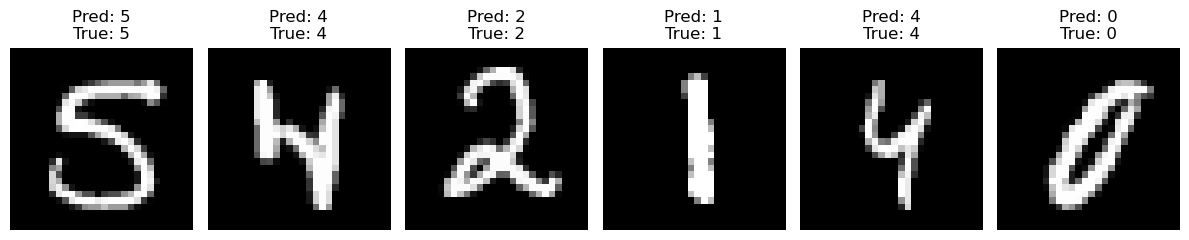

In [7]:
random_indices = np.random.randint(0, len(test_dataset), size=6)

fig = plt.figure(figsize=(12, 4))

model.eval()
for idx, img_idx in enumerate(random_indices):
    # Get image and label
    image, label = test_dataset[img_idx]

    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  # Add batch dimension
        output = model(image)
        pred = output.argmax(dim=1).cpu().item()
    
    # Plot
    ax = fig.add_subplot(1, 6, idx+1)
    ax.imshow(image.cpu().squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Pred: {pred}\nTrue: {label}')

plt.tight_layout()
plt.show()


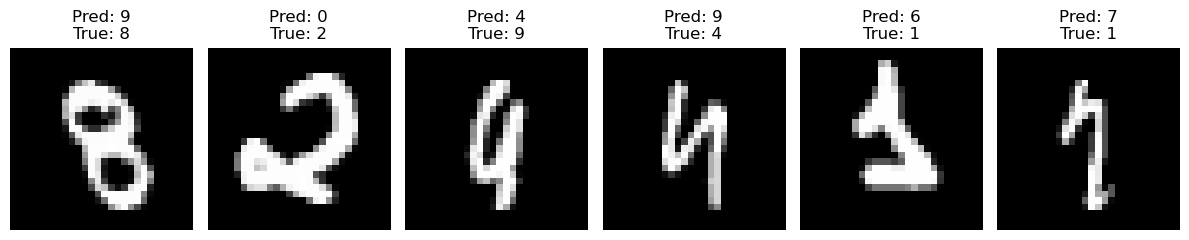

In [8]:
random_indices = np.random.choice(len(wrong_predictions), 6, replace=False)

fig = plt.figure(figsize=(12, 4))

for plot_idx, idx in enumerate(random_indices):
    sample = wrong_predictions[idx]
    ax = fig.add_subplot(1, 6, plot_idx + 1)
    ax.imshow(sample['image'].squeeze(), cmap='gray')
    ax.set_axis_off()
    ax.set_title(f'Pred: {sample["pred"]}\nTrue: {sample["true"]}')

plt.tight_layout()
plt.show()

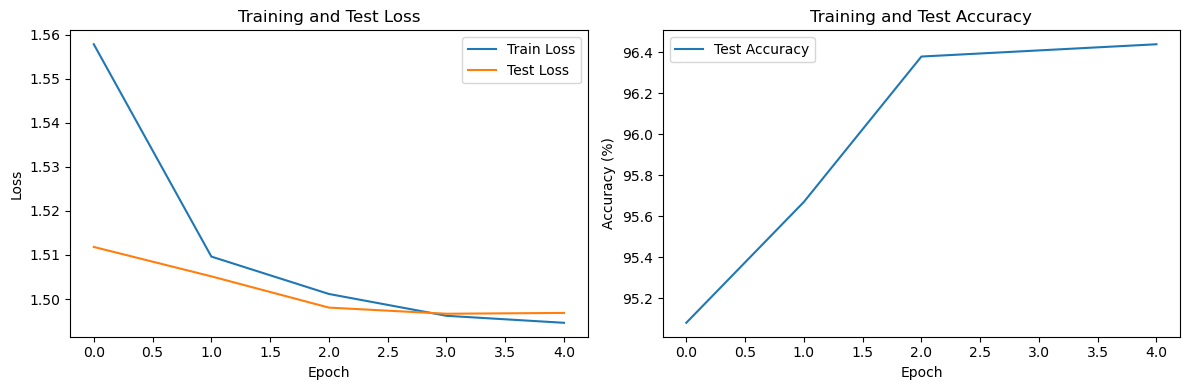

In [9]:
plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()